# Imports


In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation, utils
from scipy import fftpack

In [123]:
amplitude = 10000
sim_width = 450e-6
pixel_size = 0.01e-6 
n_slices = 1000

lens = Lens.Lens(
    diameter=sim_width,
    height=70e-6,
    exponent=2.,
    medium=Lens.Medium(2.348)
)
lens.generate_profile(pixel_size=pixel_size)
output_medium = Lens.Medium(1.)
sim_wavelength = 488e-9

35
35


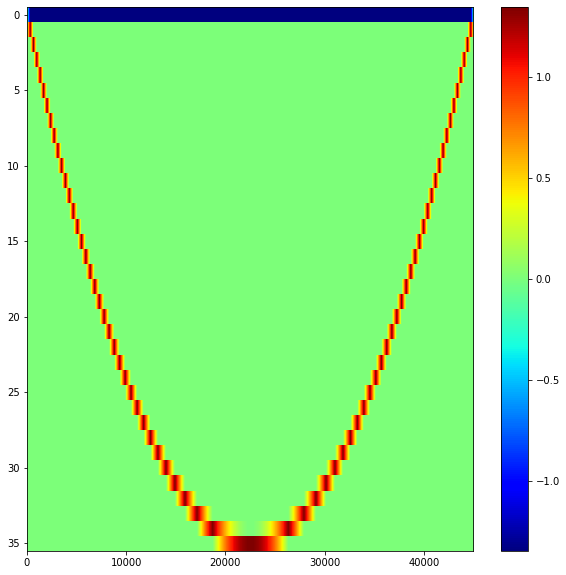

In [124]:
profile = lens.profile
# plt.plot(profile)
# plt.show()

step_size = 2e-6

d_profile = Simulation.generate_discrete_profile(lens, step_size, 1.33)
# plt.figure(figsize=(15, 15))
# plt.imshow(d_profile, aspect='auto', interpolation='None', cmap='Blues')
# plt.colorbar()
# plt.show()

d_profile[d_profile!=0] = d_profile[d_profile!=0] / step_size

# plt.figure(figsize=(15, 15))
# plt.imshow(d_profile, aspect='auto', interpolation='None', cmap='Blues')
# plt.colorbar()
# plt.show()

d_profile[d_profile!=0] = d_profile[d_profile!=0] * lens.medium.refractive_index

# plt.figure(figsize=(15, 15))
# plt.imshow(d_profile, aspect='auto', interpolation='None', cmap='Blues')
# plt.colorbar()
# plt.show()

d_profile = Simulation.generate_discrete_profile(lens, step_size, 1.33)
d_profile[d_profile!=0] = d_profile[d_profile!=0] / step_size
d_profile[d_profile!=0] = d_profile[d_profile!=0] * lens.medium.refractive_index + (1-d_profile[d_profile!=0]) * output_medium.refractive_index
d_profile[d_profile==0] = output_medium.refractive_index

# plt.figure(figsize=(15, 15))
# plt.imshow(d_profile, aspect='auto', interpolation='None', cmap='jet')
# plt.colorbar()
# plt.show()


d_profile[1:] = d_profile[:-1] - d_profile[1:]
d_profile[0] = len(lens.profile) * [1.] - d_profile[0]
phase_diff_profile = d_profile
plt.figure(figsize=(10, 10))
plt.imshow(d_profile, aspect='auto', interpolation='None', cmap='jet')
plt.colorbar()
plt.show()




C:\Users\Admin\Anaconda3\envs\Lens_Simulations\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


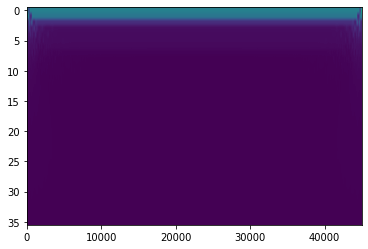

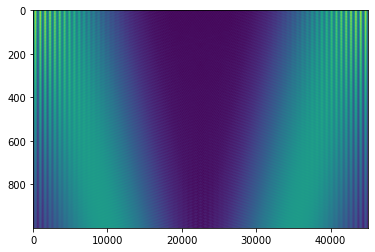

In [125]:

medium = output_medium
z_step = step_size

freq_array = Simulation.generate_squared_frequency_array(n_pixels=len(lens.profile), pixel_size=pixel_size)


wavefronts = np.zeros(shape=phase_diff_profile.shape)
outputs = np.zeros(shape=phase_diff_profile.shape)


for i, slice in enumerate(phase_diff_profile):
    delta = slice * z_step
    phase = (2 * np.pi * delta / sim_wavelength) % (2 * np.pi)

    if i == 0:
        wavefront = 1 * np.exp(1j*phase)
    else:
        current_wavefront = 1 * np.exp(1j * phase)
        wavefront = current_wavefront * wavefronts[i-1]

    wavefront = fftpack.fft(wavefront)

    propagator = np.exp(1j * medium.wave_number * z_step * (i+1))  * np.exp( (-1j * 2 * np.pi ** 2 * (z_step * (i+1)) * freq_array) / medium.wave_number)
    propagation = fftpack.ifft(propagator * wavefront)

    output = np.sqrt(propagation.real**2 + propagation.imag**2)
    wavefronts[i] = propagation
    outputs[i] = output

plt.imshow(outputs, aspect='auto')
plt.show()

sim = np.ones(shape=(n_slices, len(lens.profile)))

equivalent_focal_distance = Simulation.calculate_equivalent_focal_distance(lens, medium)
start_distance = 0.5 * equivalent_focal_distance  # 25e-3
finish_distance = 1.5 * equivalent_focal_distance  # 28e-3

#####

# delta = (lens.medium.refractive_index - medium.refractive_index) * lens.profile
# phase = (2 * np.pi * delta / medium.wavelength_medium) % (2 * np.pi)
# wavefront = 10000 * np.exp(1j * phase)

# print("Wavefront shape: ", wavefront.shape)
# wavefront = fftpack.fft(wavefront)


#####
distances = np.linspace(start_distance, finish_distance, n_slices)
for i, z in enumerate(distances):
    wavefront = fftpack.fft(wavefronts[-1])
    # wavefront = wavefronts[-1]
    prop = np.exp(1j * medium.wave_number * z)  * np.exp( (-1j * 2 * np.pi ** 2 * z * freq_array) / medium.wave_number)
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop * wavefront)

    output = np.sqrt(propagation.real**2 + propagation.imag**2)

    sim[i] = output
    # print(f'Slice: {i} complete')

plt.imshow(sim, aspect='auto')
plt.show()



In [ ]:

medium = output_medium
z_step = step_size

freq_array = Simulation.generate_squared_frequency_array(n_pixels=len(lens.profile), pixel_size=pixel_size)


wavefronts = np.zeros(shape=phase_diff_profile.shape)
outputs = np.zeros(shape=phase_diff_profile.shape)


for i, slice in enumerate(phase_diff_profile):
    delta = slice * z_step
    phase = (2 * np.pi * delta / sim_wavelength) % (2 * np.pi)

    if i == 0:
        wavefront = 1 * np.exp(1j*phase)
    else:
        current_wavefront = 1 * np.exp(1j * phase)
        wavefront = current_wavefront * wavefronts[i-1]

    wavefront = fftpack.fft(wavefront)

    propagator = np.exp(1j * medium.wave_number * z_step * (i+1))  * np.exp( (-1j * 2 * np.pi ** 2 * (z_step * (i+1)) * freq_array) / medium.wave_number)
    propagation = fftpack.ifft(propagator * wavefront)

    output = np.sqrt(propagation.real**2 + propagation.imag**2)
    wavefronts[i] = propagation
    outputs[i] = output

plt.imshow(outputs, aspect='auto')
plt.show()

sim = np.ones(shape=(n_slices, len(lens.profile)))

equivalent_focal_distance = Simulation.calculate_equivalent_focal_distance(lens, medium)
start_distance = 2.5 * equivalent_focal_distance  # 25e-3
finish_distance = 4. * equivalent_focal_distance  # 28e-3

#####

# delta = (lens.medium.refractive_index - medium.refractive_index) * lens.profile
# phase = (2 * np.pi * delta / medium.wavelength_medium) % (2 * np.pi)
# wavefront = 10000 * np.exp(1j * phase)

# print("Wavefront shape: ", wavefront.shape)
# wavefront = fftpack.fft(wavefront)


#####
distances = np.linspace(start_distance, finish_distance, n_slices)
for i, z in enumerate(distances):
    wavefront = fftpack.fft(wavefronts[-1])
    # wavefront = wavefronts[-1]
    prop = np.exp(1j * medium.wave_number * z)  * np.exp( (-1j * 2 * np.pi ** 2 * z * freq_array) / medium.wave_number)
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop * wavefront)

    output = np.sqrt(propagation.real**2 + propagation.imag**2)

    sim[i] = output
    # print(f'Slice: {i} complete')

plt.imshow(sim, aspect='auto')
plt.show()

